In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# import sys
# f = open("file.txt", "w")
# f.write("The test works!!")
# !cp f

# attempting to save colab file to shared google drive

# import sys
# f = open("file.txt", "w")
# f.write("The")
# !cp f

# with open('/content/drive/My Drive/file.txt', 'w') as f:
#  f.write('testing')

# import shutil
# colab_link = "/content/filename.type"
# gdrive_link = "/content/drive/MyDrive/Shared with me/Colab Notebooks/Models"
# shutil.copy(colab_link, gdrive_link)

Mounted at /content/drive


In [3]:
import h5py

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
# file = "/content/drive/Shared with me/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')

def h5_items(file):
    for key in file:
        if isinstance(file[key],h5py.Dataset):
                print('' + key + ':' + str(file[key].shape))
        else:
            print('' + key)
            h5_items(file[key])
subsetSize=20000
splicingVal = 11
numOutputs = 220/splicingVal
sample = hf["sample_id"][0:subsetSize]
imgs = hf['images'][0:subsetSize]
spectra = hf['spectra'][0:subsetSize]
spectra = np.array([x[::splicingVal] for x in spectra])
x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, random_state = None)

In [ ]:
from keras.backend import softsign
#Testing Model
def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation= softsign)])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
import sys
sys.stdout = open('EpochOutput.txt', 'w') 
numNetworks = 5
modelList = []
historyList= []
epochs = 50
batch_size = 32
#trainSub = int(len(x_train)/numNetworks)
#testSub =  int(len(x_test)/numNetworks)
for i in range(numNetworks):
  normal_model = get_conv_model_normal()
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1)
  modelList.append(normal_model)
  historyList.append(normal_history)
#sys.stdout.close()
def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]
  
def ensemblePredictAverage(predictList, ele):
  numNetworks = len(modelList)
  prediction = 0
  for predict in predictList:
    prediction += predict[ele]
  return prediction/numNetworks

In [ ]:
# neural network from ensemble
# fix data input tho
# x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, random_state = None)
def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, 20)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation= 'softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = ['accuracy'])
    return model

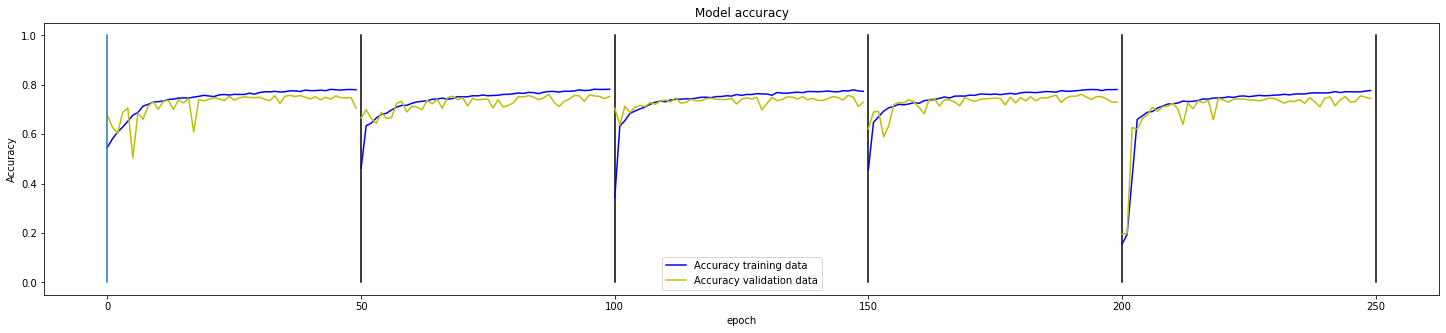

In [ ]:
fig = plt.figure(figsize=(25, 5))

for i, normal_history in enumerate(historyList):
  x = np.array([x for x in range(50)])
  plt.plot(x + 50*i, normal_history.history['accuracy'], color = 'b')
  plt.plot(x + 50*i, normal_history.history['val_accuracy'], color = 'y')
  plt.plot([50*(i+1),50*(i+1)],[0,1], color='black')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.savefig('ModelAccuracy.jpg')
  plt.legend(['Accuracy training data', 'Accuracy validation data'])
plt.plot([0,0],[0,1])
plt.show()

In [ ]:
import random
#Make First 10 images on 1 graph
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'y')
  plt.plot(x + 220*i, y_train[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.savefig('First10.jpg')
plt.show()

#Make Random 10 images on 1 graph
rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'y')
  plt.plot(x + 220*i, y_train[rand], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.savefig('Random10.jpg')
plt.show()

InternalError: ignored

In [ ]:
# Use this if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored

In [ ]:
import random
#Make First 10 predictions all on the same graph
# must add 'AllPredictions' to next code block for this image to save
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')      # ---gives yellow prediction lines
 # plt.plot(x, y_train[i], color = 'b') ---gives actual data lines
  plt.legend(['predict'], loc='upper left')   # add 'actual' to get blue legend thing
plt.savefig('AllPredictions.jpg')
plt.show()

InternalError: ignored

In [ ]:
# this uploads the colab_link to your google drive and the files will be in models

import shutil
# names = ['EpochOutput.txt', 'First10.jpg', 'ModelAccuracy.jpg', 'Model.h5', 'Random10.jpg']
names = ['EpochOutput.txt', 'First10.jpg', 'ModelAccuracy.jpg', 'Random10.jpg']
for name in names:
  colab_link = name
  gdrive_link = "/content/drive/My Drive/Colab Notebooks"
  shutil.copy(colab_link, gdrive_link)

In [ ]:
def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)  # this is squared loss difference
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 
